# Tests implementation of : http://biorxiv.org/content/10.1101/315838v1.full.pdf 




First processing the video and define a color traker for marker on the plant 


In [28]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
import os



In [29]:

#
# helper functions
#
def rgb_to_hsv(r, g, b):
    rgb = np.uint8([[[r, g, b]]])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    return hsv[0][0]

def create_hsv_bounds(h, s, v, tolerance=0.07):
    lower_bound = np.array([h - (180 * tolerance), max(0, s - (255 * tolerance)), max(0, v - (255 * tolerance))])
    upper_bound = np.array([h + (180 * tolerance), min(255, s + (255 * tolerance)), min(255, v + (255 * tolerance))])
    return lower_bound, upper_bound



# video processing on background sub
def process_video_background_sub(video_path):
    # Load the video
    cap = cv2.VideoCapture(video_path)
    
    # Initialize the background subtractor
    background_subtractor = cv2.createBackgroundSubtractorMOG2()

    marker_positions = []

    # Define the lower and upper bounds for the red color
    red_color = (200, 132, 133)
    red_hsv = rgb_to_hsv(*red_color)
    lower_red, upper_red = create_hsv_bounds(*red_hsv)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Apply the background subtractor
        foreground_mask = background_subtractor.apply(frame)

        # Apply a Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(foreground_mask, (5, 5), 0)

        # Threshold the image to get a binary mask
        _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

        # Find contours in the thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Convert the frame to HSV
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        for cnt in contours:
            # Calculate the area of the contour
            area = cv2.contourArea(cnt)

            # Ignore small contours (noise)
            if area < 50:
                continue

            # Calculate the center of the contour
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            # Check if the marker color is within the red bounds
            if in_red_bounds(hsv_frame[cy, cx], lower_red, upper_red):
                marker_positions.append((cx, cy))
                break

    cap.release()
    return marker_positions

def in_red_bounds(pixel, lower_bound, upper_bound):
    return np.all(lower_bound <= pixel) and np.all(pixel <= upper_bound)



In [30]:
# Step 1: Video Processing with marker based on pixel color of the img 
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    positions = []

    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Define the lower and upper bounds for the red color
        red_color = (200, 132, 133)
        red_hsv = rgb_to_hsv(*red_color)
        lower_red, upper_red = create_hsv_bounds(*red_hsv)


        # Threshold the frame to keep only the red pixels
        mask = cv2.inRange(hsv_frame, lower_red, upper_red)
        
        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find the largest contour (assuming it's the marker)
        if contours:
            max_contour = max(contours, key=cv2.contourArea)
            
            # Calculate the centroid of the contour
            M = cv2.moments(max_contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                positions.append((cx, cy))

    cap.release()
    return positions



In [31]:
def crop_video(input_video_path, output_video_path, top_percentage, right_percentage):
    cap = cv2.VideoCapture(input_video_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (int(width * right_percentage), int(height * top_percentage)))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Crop the frame
        cropped_frame = frame[:int(height * top_percentage), :int(width * right_percentage)]

        # Write the cropped frame
        out.write(cropped_frame)

    # Release everything if the job is finished
    cap.release()
    out.release()

In [32]:
def process_video_threesold(video_path):
    cap = cv2.VideoCapture(video_path)
    marker_positions = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Crop the frame
        #frame = crop_image(frame)
        
        # Convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Define the lower and upper bounds for the red color
        red_color = (200, 132, 133)
        red_hsv = rgb_to_hsv(*red_color)
        lower_red, upper_red = create_hsv_bounds(*red_hsv)

        # Threshold the HSV image to get only red colors
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Find the contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            moment = cv2.moments(largest_contour)
            if moment["m00"] != 0:
                marker_x = int(moment["m10"] / moment["m00"])
                marker_y = int(moment["m01"] / moment["m00"])
                marker_positions.append((marker_x, marker_y))

    cap.release()
    return marker_positions


In [36]:
input_video_path = './AraVib/mov/movie_tmp/test_flex.mov'
#test_001.mov
output_video_path = './output_frames/test.avi'
top_percentage = 0.6
right_percentage = 0.89

crop_video(input_video_path, output_video_path, top_percentage,right_percentage)

positions_marker = process_video(output_video_path)
position_background = process_video_background_sub(output_video_path)
position_threesold = process_video_threesold(output_video_path)

In [37]:
positions_marker[:3]

[(311, 410), (311, 406), (311, 406)]

In [38]:
len(positions_marker)

1582

In [39]:
position_background

[(310, 413), (309, 406)]

In [40]:
len(position_threesold) 

1582

# Verification of the market and images croping 

In [41]:
# verification 
def visualize_positions(video_path, positions):
    cap = cv2.VideoCapture(video_path)
    output_dir = "output_frames"
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        
        if frame_index < len(positions):
            cx, cy = positions[frame_index]
            
            # Draw a circle at the estimated position
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)
            
            # Save the frame as an image file
            cv2.imwrite(f"{output_dir}/frame_{frame_index:04d}.png", frame)
            
            frame_index += 1

    cap.release()


In [42]:
#positions = process_video(video_path)
visualize_positions(output_video_path, positions_marker)


In [43]:
#plot backgroung sub frames 

def save_processed_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    background_subtractor = cv2.createBackgroundSubtractorMOG2()
    frame_number = 0

    red_color = (200, 132, 133)
    red_hsv = rgb_to_hsv(*red_color)
    lower_red, upper_red = create_hsv_bounds(*red_hsv)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        foreground_mask = background_subtractor.apply(frame)
        blurred = cv2.GaussianBlur(foreground_mask, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 50:
                continue

            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            if in_red_bounds(hsv_frame[cy, cx], lower_red, upper_red):
                # Draw a larger green circle
                cv2.circle(frame, (cx, cy), 10, (0, 255, 0), -1)
                
                # Draw a bounding box around the contour
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                break

        output_frame_path = os.path.join(output_folder, f"frame{frame_number:04d}.png")
        cv2.imwrite(output_frame_path, frame)
        frame_number += 1

    cap.release()


save_processed_frames(output_video_path, "background_sub_img")


In [44]:
def generate_waveform_from_vid(video_path):
    cap = cv2.VideoCapture(video_path)
    background_subtractor = cv2.createBackgroundSubtractorMOG2()
    positions = []

    red_color = (200, 132, 133)
    red_hsv = rgb_to_hsv(*red_color)
    lower_red, upper_red = create_hsv_bounds(*red_hsv)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Color-based approach
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        red_mask = cv2.inRange(hsv_frame, lower_red, upper_red)
        red_mask = cv2.erode(red_mask, None, iterations=2)
        red_mask = cv2.dilate(red_mask, None, iterations=2)

        contours_color, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Background subtraction approach
        foreground_mask = background_subtractor.apply(frame)
        blurred = cv2.GaussianBlur(foreground_mask, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
        contours_bg, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Combine both sets of contours
        contours = contours_color + contours_bg

        best_contour = None
        max_area = -1

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 50:
                continue

            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            if in_red_bounds(hsv_frame[cy, cx], lower_red, upper_red):
                if area > max_area:
                    max_area = area
                    best_contour = cnt

        if best_contour is not None:
            M = cv2.moments(best_contour)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            positions.append((cx, cy))

    cap.release()
    return positions


In [45]:
global_marker_positions = generate_waveform_from_vid(output_video_path)


In [46]:
len(global_marker_positions)

18

you can know see every images and the marker position for each images inside the `output_frames`


# Computing metrics from frames 

In [47]:
def plot_metric(marker_positions, frequencies, fft_values):

    # Plot the displacement data
    plt.plot(np.array(marker_positions)[:, 1])
    plt.title("Displacement data")
    plt.xlabel("Frame")
    plt.ylabel("Displacement")
    plt.show()

    # Plot the Hanning windowed displacement data
    plt.plot(np.array(marker_positions)[:, 1] * np.hanning(len(marker_positions)))
    plt.title("Hanning windowed displacement data")
    plt.xlabel("Frame")
    plt.ylabel("Displacement")
    plt.show()

    # Plot the FFT values
    plt.plot(frequencies, np.abs(fft_values))
    plt.title("Fast Fourier Transform")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

def damped_natural_frequency(frequencies, fft_values):
    # Find the index of the maximum amplitude
    max_amplitude_index = np.argmax(np.abs(fft_values))
    
    # Obtain the corresponding frequency
    omega_d = frequencies[max_amplitude_index]
    
    return omega_d

In [48]:
def calculate_frequencies_and_fft(marker_positions):
    marker_positions = np.array(marker_positions)
    
    # Calculate the y-displacement from the initial position
    initial_position = marker_positions[0, 1]
    displacements = marker_positions[:, 1] - initial_position

    # Apply the Hanning window function
    window = np.hanning(len(displacements))
    hanning_displacements = displacements * window

    # Perform the Fast Fourier Transform (FFT)
    frequencies = np.fft.rfftfreq(len(hanning_displacements))
    fft_values = np.fft.rfft(hanning_displacements)

    return frequencies, fft_values

frequencies, fft_values = calculate_frequencies_and_fft(positions_marker)


In [49]:
# Calculate the damped natural frequency
omega_d = damped_natural_frequency(frequencies, fft_values)
print(f"Damped natural frequency | background sub method (ωd): {omega_d}")




Damped natural frequency | background sub method (ωd): 0.0012642225031605564


In [50]:
plot_metric(marker_positions, frequencies, fft_values)

NameError: name 'marker_positions' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_waveform(marker_positions):
    marker_positions = np.array(marker_positions)
    
    # Calculate the y-displacement from the initial position
    initial_position = marker_positions[0, 1]
    displacements = marker_positions[:, 1] - initial_position

    # Apply the Hanning window function
    window = np.hanning(len(displacements))
    hanning_displacements = displacements * window

    # Perform the Fast Fourier Transform (FFT)
    frequencies = np.fft.rfftfreq(len(hanning_displacements))
    fft_values = np.fft.rfft(hanning_displacements)

    return frequencies, fft_values

# Example marker positions
marker_positions = positions_marker

# Generate the waveform and perform FFT
frequencies, fft_values = generate_waveform(marker_positions)




In [ ]:
plot_metric(marker_positions, frequencies, fft_values)

# Compute the natural frequency (ωd)

In [ ]:


# Calculate the damped natural frequency
omega_d = damped_natural_frequency(frequencies, fft_values)
print(f"Damped natural frequency | marker method (ωd): {omega_d}")


In [ ]:
def damped_natural_frequency(frequencies, fft_values):
    # Find the index of the maximum amplitude
    max_amplitude_index = np.argmax(np.abs(fft_values))
    
    # Obtain the corresponding frequency
    omega_d = frequencies[max_amplitude_index]
    
    return omega_d



In [7]:
input_video_path = './AraVib/mov/movie_tmp/test_001.mov'
#test_001.mov
output_video_path = './output_frames/test.avi'

# test aravib style

## try to refactor `AraVib_modules.AraVib_body`

the goal here is to test with the sample data the author has left in `./AraVib/mov/movie_tmp/test_001.mov`and see if the results fits...

In [8]:
import cv2
import numpy as np
import os

def process_video(video_path):
    # Define the lower and upper bounds for the red color
    red_color = (200, 132, 133)
    red_hsv = rgb_to_hsv(*red_color)
    lower_bound, upper_bound = create_hsv_bounds(*red_hsv)

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    center_positions = []

    kernel1 = np.ones((2,2),np.uint8)
    kernel2 = np.ones((15,15),np.uint8)

    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to HSV color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Apply the color filter
        mask = cv2.inRange(hsv, lower_bound, upper_bound)

        # Apply erosion and dilation
        mask = cv2.erode(mask, kernel1, iterations=1)
        mask = cv2.dilate(mask, kernel2, iterations=1)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the contour with the largest area
            c = max(contours, key=cv2.contourArea)
            M = cv2.moments(c)

            if M["m00"] != 0:
                # Calculate the center of the contour
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                center_positions.append([cX, cY])

    cap.release()

    center_positions = np.array(center_positions)
    displacement_array = center_to_displacement(center_positions)

    return displacement_array


def center_to_displacement(center_array):
    displacement_array = np.array([np.linalg.norm(i - center_array[0]) for i in center_array])
    return displacement_array

def rgb_to_hsv(r, g, b):
    rgb = np.uint8([[[r, g, b]]])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    return hsv[0][0]

def create_hsv_bounds(h, s, v, tolerance=0.1):
    lower_bound = np.array([h - (180 * tolerance), max(0, s - (255 * tolerance)), max(0, v - (255 * tolerance))])
    upper_bound = np.array([h + (180 * tolerance), min(255, s + (255 * tolerance)), min(255, v + (255 * tolerance))])
    return lower_bound, upper_bound


In [22]:
displacement_array = process_video(input_video_path)

In [23]:
displacement_array


array([ 48.48901335,  72.1672922 ,  70.25219649, ..., -48.84697301,
        -5.78162302,  -1.92696174])

Major frequency: 5.000000000000001 Hz


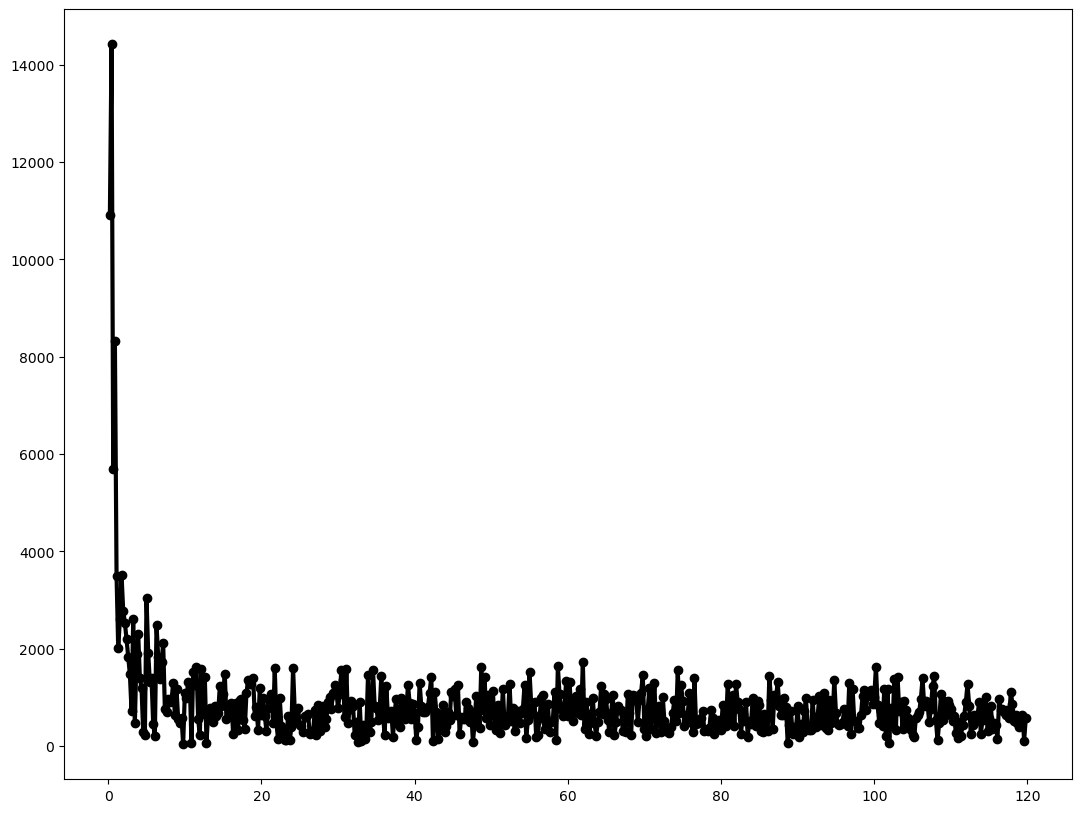

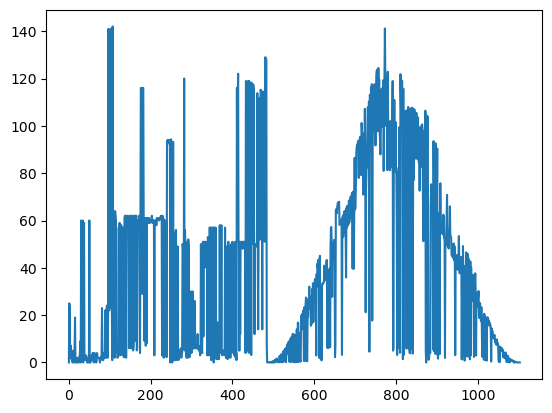

In [16]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt

def displacement_to_difference(displacement_array):
    dif_array = np.diff(displacement_array)
    start_point = np.argmin(dif_array)
    return dif_array, start_point

def transform_hanning(displacement_array, start_point):
    hanning_window = np.hanning(len(displacement_array[start_point:]))
    displacement_array[start_point:] *= hanning_window
    return displacement_array

def displacement_to_major_freq(displacement_array, fps=240):
    time_step = 1/fps
    freq = fftpack.fftfreq(len(displacement_array), d=time_step)
    fft = fftpack.fft(displacement_array)

    # Only consider positive frequencies
    pidxs = np.where(freq > 0)
    freqs = freq[pidxs]
    power = np.abs(fft)[pidxs]

    # Only consider frequencies above 2 Hz
    freqs2 = freqs[freqs > 2]
    power2 = power[freqs > 2]
    major_freq = freqs2[np.argmax(power2)]
    
    return freqs, power, major_freq

def freqs_power_graph(freqs, power, col="k"):
    plt.figure(figsize=(13,10))
    plt.plot(freqs, power, color=col, marker=".", markersize=12, linewidth=3)
    plt.show()

def plot_graph(data):
    plt.figure()
    plt.plot(data)
    plt.show()

# Usage
dif_array, start_point = displacement_to_difference(displacement_array)
displacement_array = transform_hanning(displacement_array, start_point)
freqs, power, major_freq = displacement_to_major_freq(displacement_array)

print(f"Major frequency: {major_freq} Hz")

freqs_power_graph(freqs, power)
plot_graph(displacement_array)


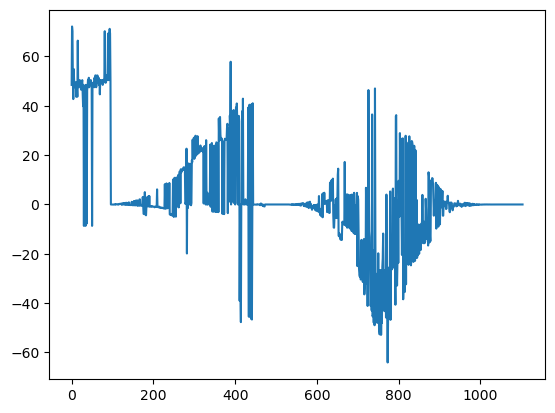

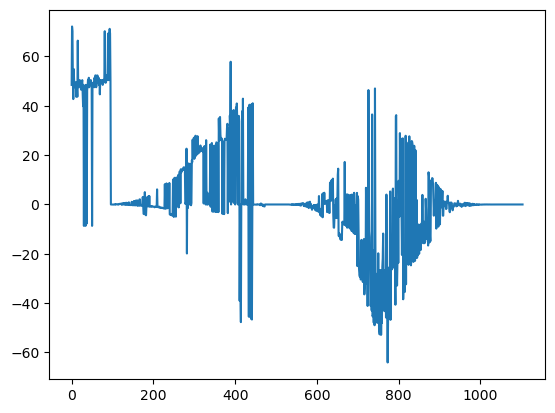

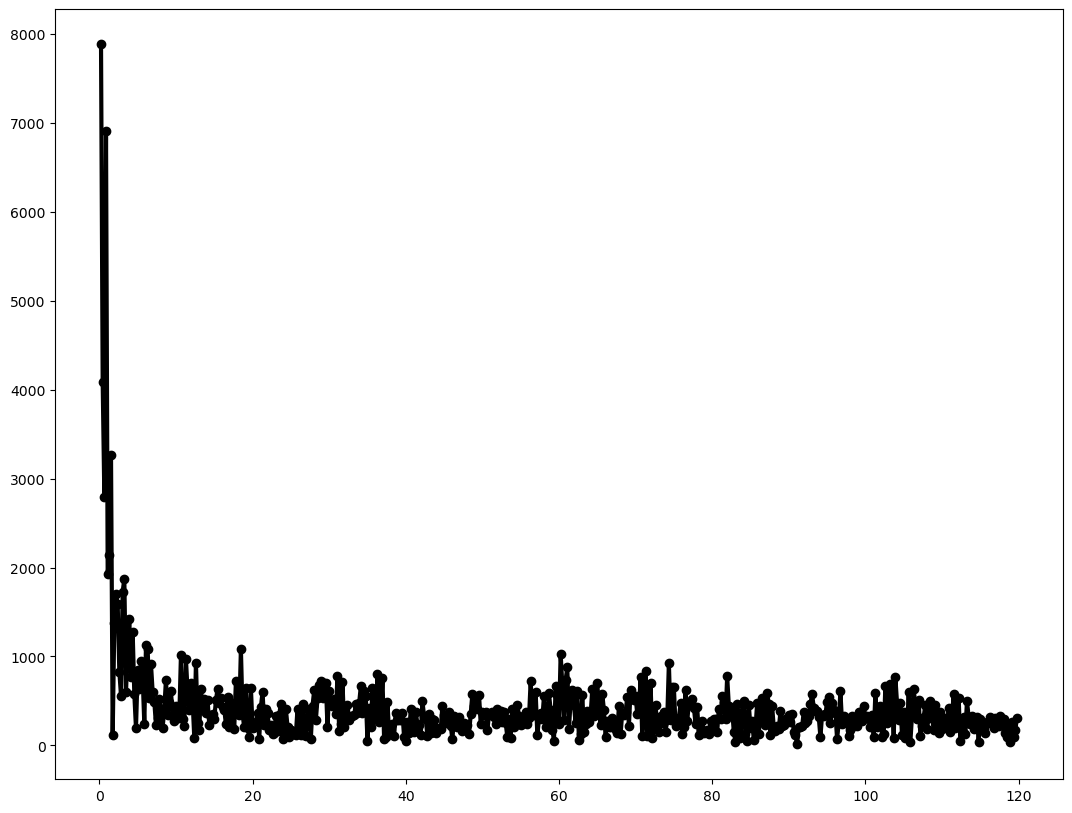

Runtime = 0.1319s


In [27]:
import time
import matplotlib.pyplot as plt


start = time.time()

#displacement_array = process_video(video_path)

dif_array1, start_point1 = displacement_to_difference(displacement_array)
hanning_array1 = transform_hanning(displacement_array, start_point1)
freqs1, power1, major_freq1 = displacement_to_major_freq(hanning_array1)

#print("\n\n --- ωd of {} = {:.4f} Hz --- \n\n".format(sample_name,*major_freq1))

plot_graph(displacement_array)
#plt.savefig("{}_{}_displacement_vibration.png".format(date_fname,sample_name),dpi=250)
#plt.close()
plot_graph(hanning_array1)

#plt.savefig("{}_{}_hanning_vibration.png".format(date_fname,sample_name),dpi=250)
#plt.close()
freqs_power_graph(freqs1, power1, col="k")
#plt.savefig("{}_{}_fft_power_spectrum.png".format(date_fname,sample_name),dpi=250)
#plt.close()

print("Runtime = {:.4f}s".format(time.time() - start))


Apparently the results are not here, we do not have the same result in the fig 3 page 20 ... 😭